# Comparing my Data to Davidson's

Davidson's _Mortgage Valuation Models_ shows some charts of relationships between mortgage pool data and prepayment rates. I want to see if my post-2012 data set is a reasonable match. Maybe this explains negative beta on incentive.

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")

import prepayments as pp
import numpy as np
import pandas as pd
import ggplot as gg
import datetime

pm = pp.models.PoolModel()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
samples = pm.data_pool.get_samples()
samples[:5]

[(1044337, '294225', datetime.datetime(2012, 6, 1, 0, 0)),
 (72605, '388254', datetime.datetime(2012, 2, 1, 0, 0)),
 (2906725, '618699', datetime.datetime(2013, 1, 1, 0, 0)),
 (4490762, 'MA0368', datetime.datetime(2013, 7, 1, 0, 0)),
 (9076885, '148173', datetime.datetime(2015, 3, 1, 0, 0))]

# Coupon vs CPR

In [6]:
samples = [x for x in samples if x[2] > datetime.datetime(2012,9,1)]

In [11]:
samples = [x for x in samples if pm.data_pool.pools_table[x[0]]['wala'] > 1]

In [12]:
df = np.ndarray(shape=[len(samples), 2])
for i, (pi, pool_number, as_of_dt) in enumerate(samples):
    df[i,0] = pm.data_pool.cpr_for_pool_number(pool_number)[as_of_dt]
    df[i,1] = pm.data_pool.pools_table[pi]['wac']

In [16]:
df = pd.DataFrame.from_records(df, columns=['cpr','wac'])

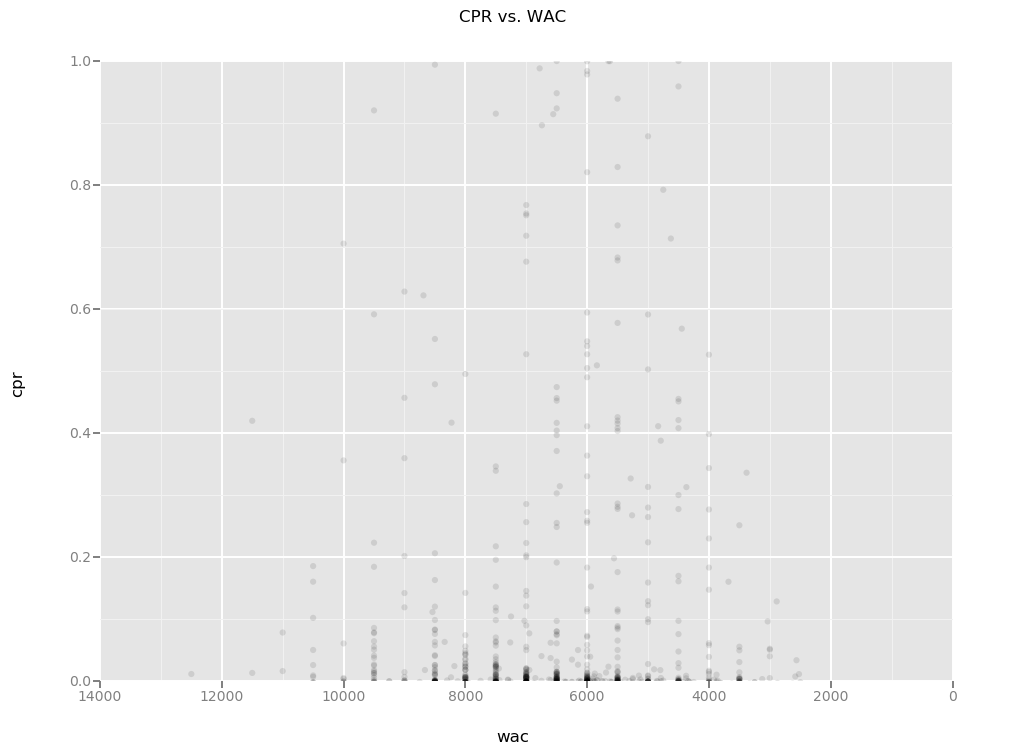

<ggplot: (8751882624973)>

In [20]:
gg.ggplot(df.where(df.wac < 20000).dropna(), gg.aes(y='cpr',x='wac')) + \
    gg.geom_point(alpha=0.1) + gg.ggtitle("CPR vs. WAC") + gg.scale_x_reverse() + gg.ylim(0,1)

Davidson shows a nice S-curve for this relationship (note X-axis reversed). You can *kind of* see it. Mostly, things are just 0, as usual.

# Can I back-sample using extra data from BBG?

My problem may be that my investment universe starts in 2012. I know I can get historical CPR from earlier than that in Bloomberg, but only for mortgage pools that still exist. What if I try to sample earlier prepayment rates using the BBG data?

What data must be retrieved from the contemporaneous set?

* wac
* wala
* pool_upb
* mip
* msas

Out of those, `pool_upb` changes, but it's only relevant for CPR. `wala` is determinable. What about `wac`?

How much does WAC change over time?

In [22]:
df = pm.data_pool.df_for_pool_number(samples[40][1])

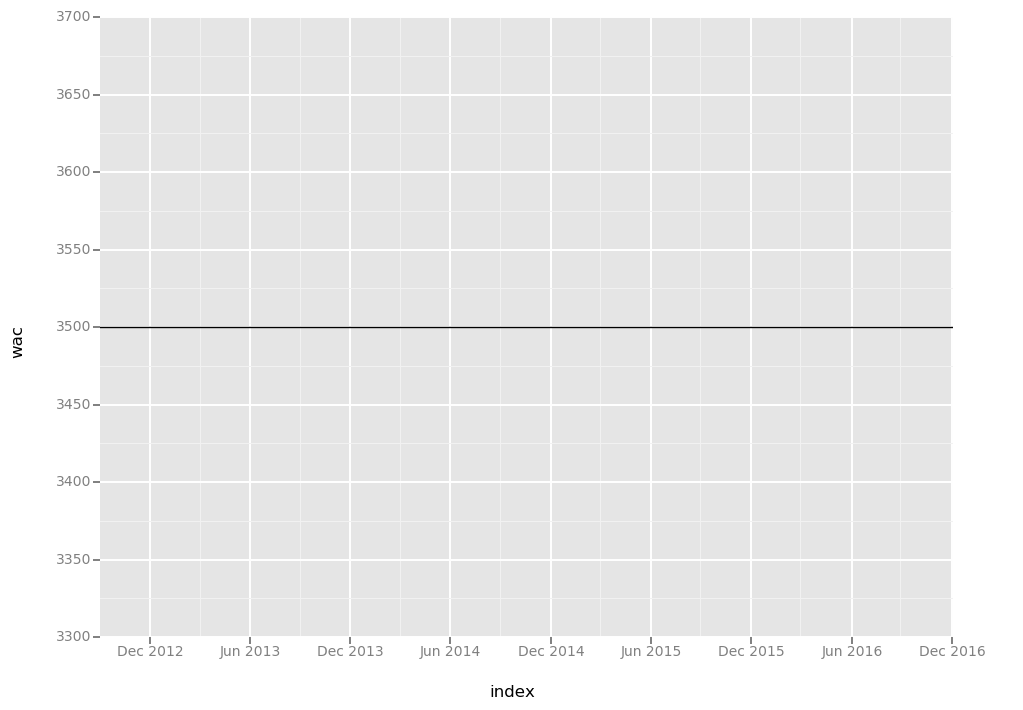

<ggplot: (8751882560681)>

In [25]:
gg.ggplot(df.reset_index(), gg.aes(x='index', y='wac')) + gg.geom_line()

In [32]:
wacs_diff = pd.DataFrame()
for pi, pool_number, as_of_dt in samples[1:100]:
    wac = pm.data_pool.df_for_pool_number(pool_number)['wac']
    wac = wac.where(wac < 99999).dropna()
    wacs_diff[pi] = wac.diff()

In [33]:
pd.melt(wacs_diff).value.max()

195.0

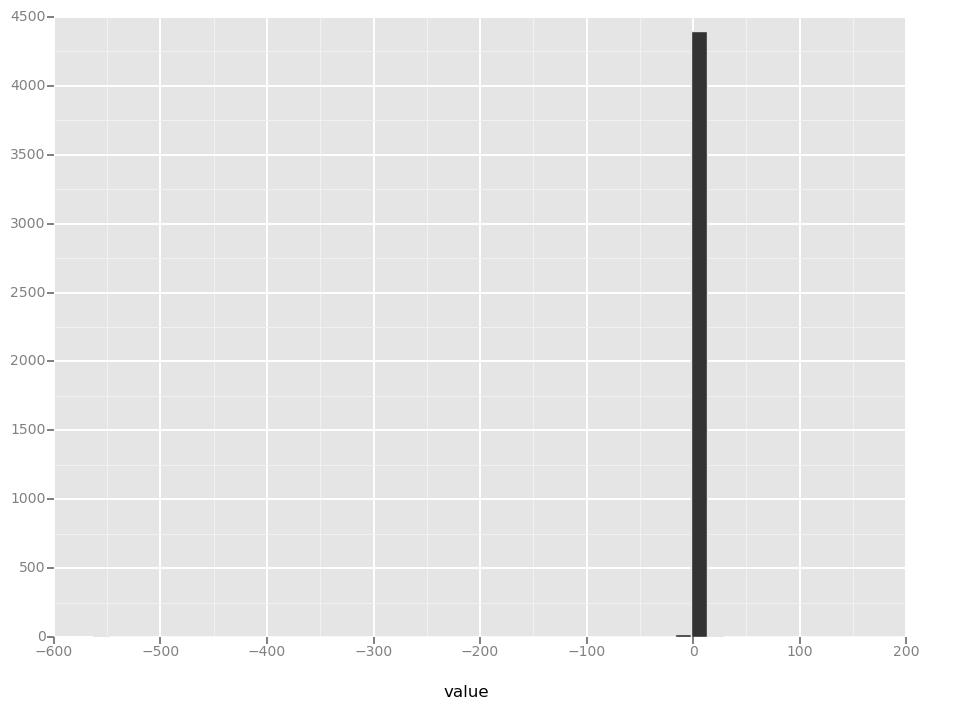

<ggplot: (8751880971425)>

In [34]:
gg.ggplot(pd.melt(wacs_diff), gg.aes(x='value')) + gg.geom_histogram(bins=50)

In [47]:
sum(wacs_diff.values > 0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


array([ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  3,  0,  0, 15,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  4,  0,  0,  0,
        0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [49]:
wacs_diff.iloc[:,22]

2012-09-01      NaN
2012-10-01      0.0
2012-11-01      3.0
2012-12-01      0.0
2013-01-01      1.0
2013-02-01      0.0
2013-03-01      0.0
2013-04-01      0.0
2013-05-01      6.0
2013-06-01      8.0
2013-07-01     -2.0
2013-08-01      0.0
2013-09-01    -13.0
2013-10-01      0.0
2013-11-01      0.0
2013-12-01      0.0
2014-01-01     -6.0
2014-02-01      0.0
2014-03-01      0.0
2014-04-01     -3.0
2014-05-01     -4.0
2014-06-01     -4.0
2014-07-01      5.0
2014-08-01      3.0
2014-09-01      0.0
2014-10-01      0.0
2014-11-01     -2.0
2014-12-01      0.0
2015-01-01     -8.0
2015-02-01      0.0
2015-03-01     -7.0
2015-04-01      0.0
2015-05-01      5.0
2015-06-01      0.0
2015-07-01     10.0
2015-08-01    -13.0
2015-09-01      3.0
2015-10-01     -5.0
2015-11-01      0.0
2015-12-01    -22.0
2016-01-01      0.0
2016-02-01      0.0
2016-03-01      0.0
2016-04-01     -5.0
2016-05-01      0.0
2016-06-01      1.0
2016-07-01     -2.0
2016-08-01      5.0
2016-09-01     14.0
2016-10-01   -563.0


In [54]:
pm.data_pool.pools_table[wacs_diff.iloc[:,22].name]['pool_number']

'082910'

In [55]:
df = pm.data_pool.df_for_pool_number('082910')

In [58]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


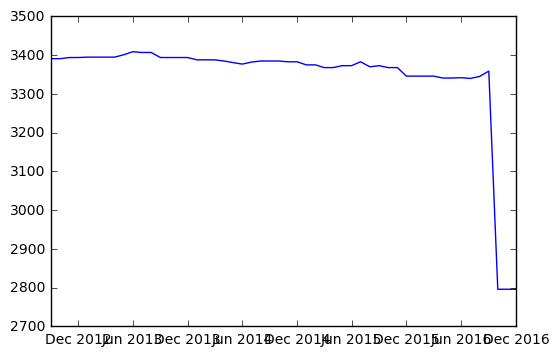

In [59]:
df.wac.plot()

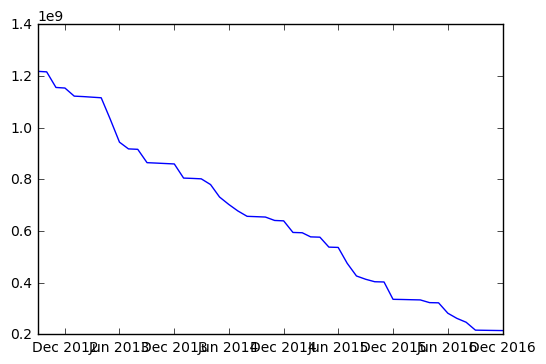

In [60]:
df.pool_upb.plot()

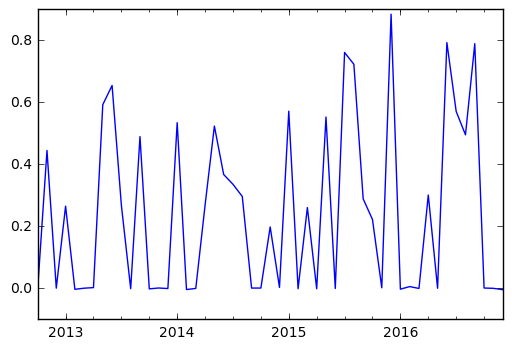

In [61]:
pm.data_pool.cpr_for_pool_number('082910').plot()

Huh. Interesting pool. It may be that the 0 wac_diff pools are the ones with no prepayments.

In [64]:
pm.data_pool.pools_table[wacs_diff.iloc[:,2].name]['pool_number']

'699689'

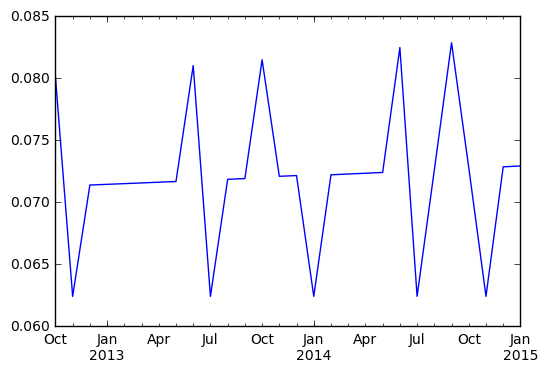

In [65]:
pm.data_pool.cpr_for_pool_number('699689').plot()

Not always, then. Still, I'd better see if I can't get historical WAC off BBG.

In [66]:
df.cusip[0]

'36225FGU7'

In [67]:
cpr_dat = pm.data_cpr

In [74]:
keys = cpr_dat.hdfstore.keys()

In [75]:
len(keys)

29598

In [76]:
keys[:5]

['/cpr/_36176A5M7',
 '/cpr/_36176A6A2',
 '/cpr/_36176A6B0',
 '/cpr/_36176A6E4',
 '/cpr/_36176A6S3']

In [77]:
keys[0][6:]

'36176A5M7'

In [78]:
bbg = pp.Bloomberg()

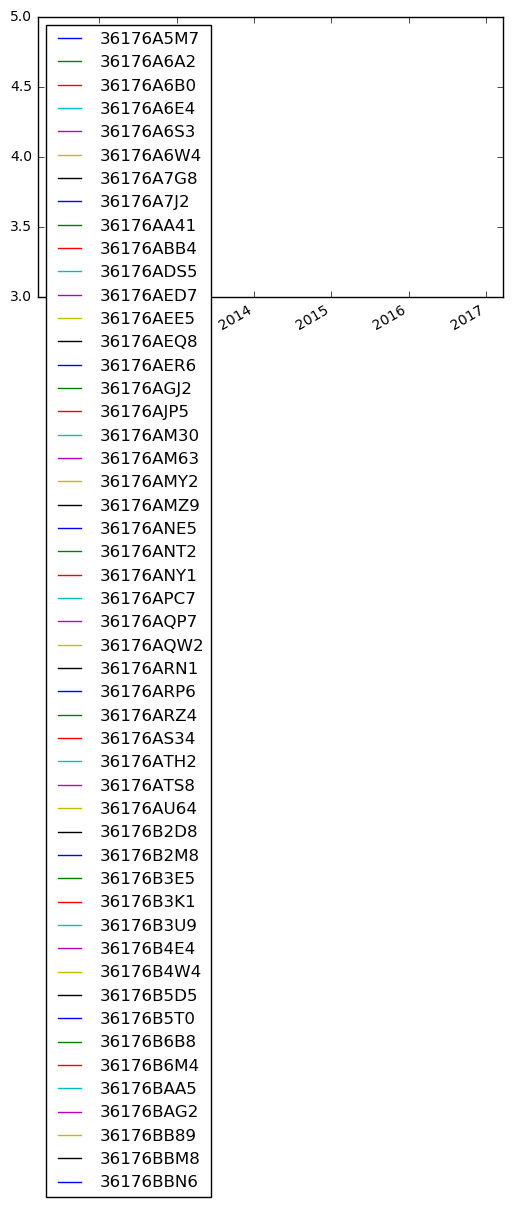

In [79]:
wac = {}
for p_key in keys[:50]:
    wac[p_key[6:]] = bbg.get_cpr(cusip=p_key[6:], field_code='MTG_HIST_CPN')
wac = pd.DataFrame(wac)
wac.plot()

In [85]:
jac = pd.DataFrame({k:v.dropna().asfreq("M", method='pad') for k,v in wac.iteritems()})
jac.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2011-03-31 to 2017-02-28
Freq: M
Data columns (total 50 columns):
36176A5M7    61 non-null float64
36176A6A2    72 non-null float64
36176A6B0    72 non-null float64
36176A6E4    72 non-null float64
36176A6S3    72 non-null float64
36176A6W4    72 non-null float64
36176A7G8    72 non-null float64
36176A7J2    72 non-null float64
36176AA41    58 non-null float64
36176ABB4    59 non-null float64
36176ADS5    71 non-null float64
36176AED7    71 non-null float64
36176AEE5    71 non-null float64
36176AEQ8    70 non-null float64
36176AER6    70 non-null float64
36176AGJ2    69 non-null float64
36176AJP5    68 non-null float64
36176AM30    71 non-null float64
36176AM63    71 non-null float64
36176AMY2    71 non-null float64
36176AMZ9    71 non-null float64
36176ANE5    70 non-null float64
36176ANT2    66 non-null float64
36176ANY1    65 non-null float64
36176APC7    61 non-null float64
36176AQP7    67 non-null float64
36176AQW2  

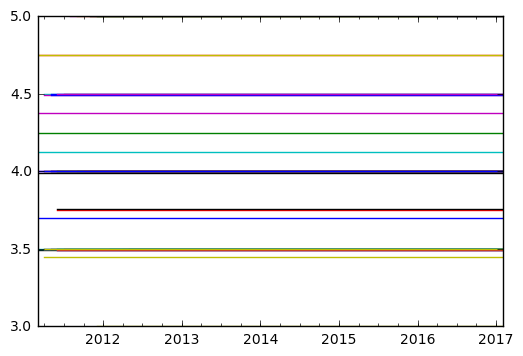

In [86]:
jac.plot(legend=False)

In [88]:
jac.diff().max().max()

0.0

None in BBG history. Let's check the next 50.

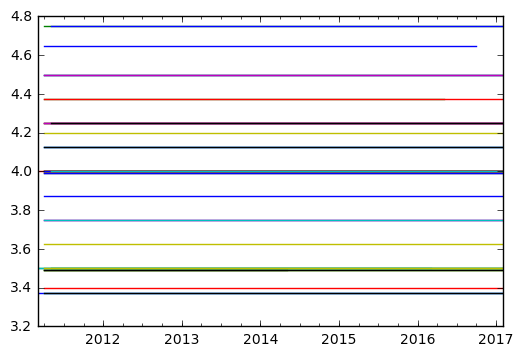

In [92]:
wac = {}
for p_key in keys[50:100]:
    wac[p_key[6:]] = bbg.get_cpr(cusip=p_key[6:], field_code='MTG_HIST_CPN')
wac = pd.DataFrame({k:v.dropna().asfreq("M",method='pad') for k,v in wac.items()})
wac.plot(legend=False)

In [93]:
wac.diff().max().max()

0.0

In [94]:
wac.index[0]

Timestamp('2011-03-31 00:00:00', freq='M')

No data before 2011, but WAC seems to be consistently constant for BBG. So I guess we can use it. 

What's the best way to choose samples from before 2012? Maybe fetch random records from the pools table, then pick a random date in that pool's lifetime from which to base analysis.

In [95]:
np.random.choice(wac.index)

numpy.datetime64('2011-10-31T00:00:00.000000000')

In [98]:
df = pm.data_pool.df_for_pool_number(samples[0][1])

In [100]:
df.index

Index([2012-09-01, 2012-10-01, 2012-11-01, 2012-12-01, 2013-01-01, 2013-02-01,
       2013-03-01, 2013-04-01, 2013-05-01, 2013-06-01, 2013-07-01, 2013-08-01,
       2013-09-01, 2013-10-01, 2013-11-01, 2013-12-01, 2014-01-01, 2014-02-01,
       2014-03-01, 2014-04-01, 2014-05-01, 2014-06-01, 2014-07-01, 2014-08-01,
       2014-09-01, 2014-10-01, 2014-11-01, 2014-12-01, 2015-01-01, 2015-02-01,
       2015-03-01, 2015-04-01, 2015-05-01, 2015-06-01, 2015-07-01, 2015-08-01,
       2015-09-01, 2015-10-01, 2015-11-01, 2015-12-01, 2016-01-01, 2016-02-01,
       2016-03-01, 2016-04-01, 2016-05-01, 2016-06-01, 2016-07-01, 2016-08-01,
       2016-09-01, 2016-10-01, 2016-11-01, 2016-12-01],
      dtype='object')

In [101]:
wac.index[0] in df.index

False

In [107]:
wac.index[0] + pd.tseries.offsets.MonthBegin(20) in pd.DatetimeIndex(df.index)

True

In [109]:
df.ix[df.index[1]]

aols                                                                           9182075
as_of_date                                                         2012-10-01 00:00:00
cusip                                                                        36290VKL7
few_units_number_of_loans                                                       999999
few_units_pct_of_upb                                                             99999
few_units_upb                                                            9999999999999
first_quartile_aols_q1                                                         8670000
first_quartile_cltv_q1                                                             999
first_quartile_ltv_q1                                                               96
first_quartile_wac_q1                                                            99999
first_quartile_wagm_q1                                                           99999
first_quartile_wala_q1                     